## The goal of this project is to generate new molecules

### Import required libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.3.1


### load Keras libraries

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

### create data load functions

In [3]:
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict  

In [4]:
## seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### load dataset & break into train/test sets

In [5]:
smifile = '../input/data-zinc/smiles_cleaned.smi'
data = load_data(smifile)
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training smiles shape:", full_train.shape)
print("Test smiles shape:", test.shape)
print("Sample training smile: \n", full_train[2])

Training smiles shape: (351278,)
Test smiles shape: (87820,)
Sample training smile: 
 Cc1cc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)ccc1F


In [6]:
# save test file for smile generation
np.save('test.npy', test)
print('Test file saved to disk')

Test file saved to disk


### create our validation dataset

In [7]:
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val_set.shape)

Training dataset shape: (316150,)
Validation dataset shape: (35128,)


### load the Python dictionaries that map characters-to-integers and intergers-to-characters

In [8]:
d1 = '../input/data-zinc/char_to_int.json'
d2 = '../input/data-zinc/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

### create a function to turn the dataset into a supervised problem, add the beginning and ending character markers, add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors

In [9]:
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

### create our X & y datasets

In [10]:
embed = 101
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Validation input shape:", X_val.shape)
print("Validation output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

Training input shape: (316150, 100, 45)
Training output shape: (316150, 100, 45)
Validation input shape: (35128, 100, 45)
Validation output shape: (35128, 100, 45)
Test input shape: (87820, 100, 45)
Test output shape: (87820, 100, 45)


The int_to_char dictionary can be used to go from the vectorized form back to a readable SMILES string, with a joined list comprehension.

### define the LSTM Chem model

In [11]:
def lstm_model(X, y):
    # define the encoder layers
    enc_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(enc_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    bottle_neck = Dense(128, activation='relu')(states)

    # define the decoder layers
    state_h_decoded = Dense(256, activation='relu')(bottle_neck)
    state_c_decoded = Dense(256, activation='relu')(bottle_neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    dec_input = Input(shape=(X.shape[1:]))
    dec1 = LSTM(256, return_sequences=True)(dec_input, initial_state=encoder_states)
    output = Dense(y.shape[2], activation='softmax')(dec1)
    
    model = Model(inputs=[enc_input, dec_input], outputs=output)   
    return model 

### instantiate our neural network model

In [12]:
model = lstm_model(X_train, y_train)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 45)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 309248      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          65664       concatenate[0][0]     

### compile the model

In [13]:
batch_size = 512
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

### define our data sequence generator class

In [14]:
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x, batch_y = np.array(x), np.array(y)
        
        return [batch_x, batch_x], batch_y

### create object instances of our sequence generator

In [15]:
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

### Create our callbacks

In [16]:
file="LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

### fit the model

In [17]:
nb_epochs = 100
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1, 
                              validation_data=validation_generator, validation_steps=validation_steps, 
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/100
617/617 [==============================] - 44s 71ms/step - loss: 0.9834 - acc: 0.7041 - val_loss: 0.6575 - val_acc: 0.7857
Epoch 2/100
617/617 [==============================] - 43s 70ms/step - loss: 0.5957 - acc: 0.8034 - val_loss: 0.5467 - val_acc: 0.8185
Epoch 3/100
617/617 [==============================] - 43s 70ms/step - loss: 0.5158 - acc: 0.8268 - val_loss: 0.5127 - val_acc: 0.8262
Epoch 4/100
617/617 [==============================] - 44s 71ms/step - loss: 0.4737 - acc: 0.8385 - val_loss: 0.4645 - val_acc: 0.8410
Epoch 5/100
617/617 [==============================] - 43s 70ms/step - loss: 0.4464 - acc: 0.8464 - val_loss: 0.4338 - val_acc: 0.8501
Epoch 6/100
617/617 [==============================] - 43s 70ms/step - loss: 0.4263 - acc: 0.8524 - val_loss: 0.4187 - val_acc: 0.8544
Epoch 7/100
617/617 [==============================] - 43s 70ms/step - loss: 0.4108 - acc: 0.8571 - val_loss: 0.4216 - val_acc: 0.8525
Epoch 8/100
617/617 [==============================] - 

### plot the model loss and accuracy

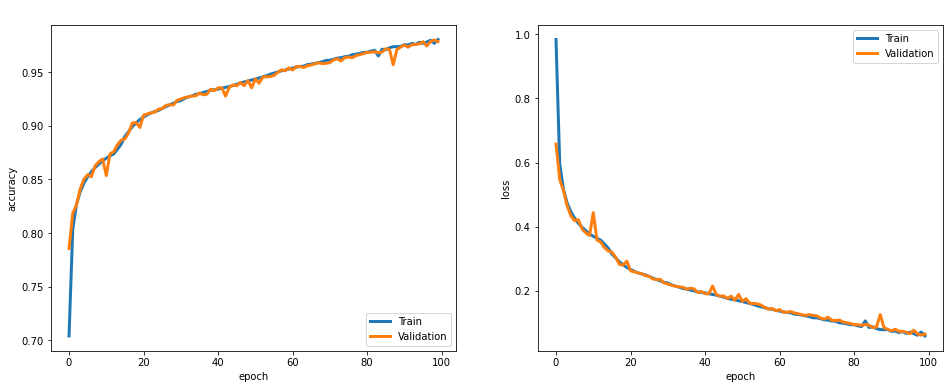

In [18]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

### evaluate our test set

In [19]:
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch_size, verbose=0)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

Test score: 0.06496881693601608
Test accuracy: 0.978509783744812


### save our training model & weights

In [20]:
mod_file = 'LSTM_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved
